In [1]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from dinov2_feature_extraction import load_model, get_dense_descriptor
from skimage import io



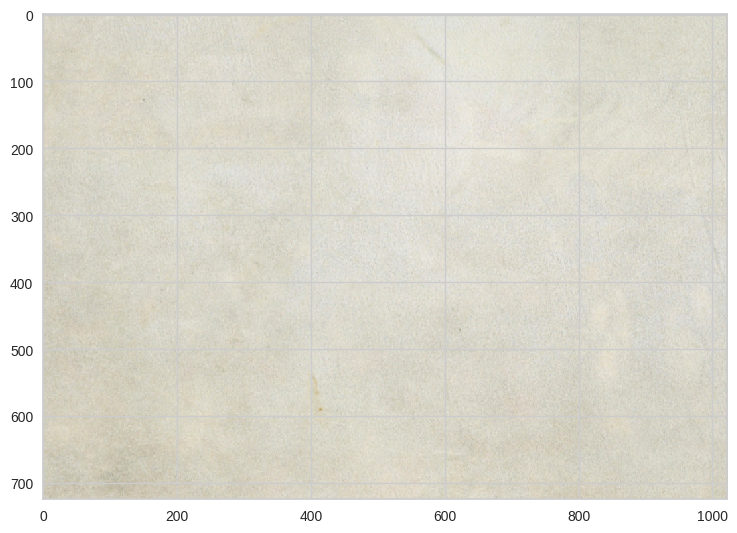

In [2]:
dataset_path_white_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page27.jpg'   
dataset_path_white_img_2 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1328.jpg'   
img = io.imread(dataset_path_white_img_1)
io.imshow(img)
io.show()

In [3]:
dinov2_sizes = {"small": 384,
                "base": 768,
                "large": 1024,
                "giant": 1536} # tamaños del feature vector de cada version de dinov2

backbone_size = 'small'
model = load_model(backbone_size)

Using cache found in /home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
features, attention, grid_shape = get_dense_descriptor(model, img)

In [14]:
import umap
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Supondo que 'attention' seja seus dados
umap_features = umap.UMAP().fit_transform(attention)

# Inicializar o modelo KMeans
model_kmeans = KMeans()

# Inicializar o KElbowVisualizer
visualizer = KElbowVisualizer(model_kmeans, k=(2,20), metric='distortion', timings=False)

# Ajustar os dados ao visualizador
visualizer.fit(umap_features)  

# Obter o número ótimo de clusters
optimal_clusters = visualizer.elbow_value_

print("Número ótimo de clusters:", optimal_clusters)

ModuleNotFoundError: No module named 'umap'

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


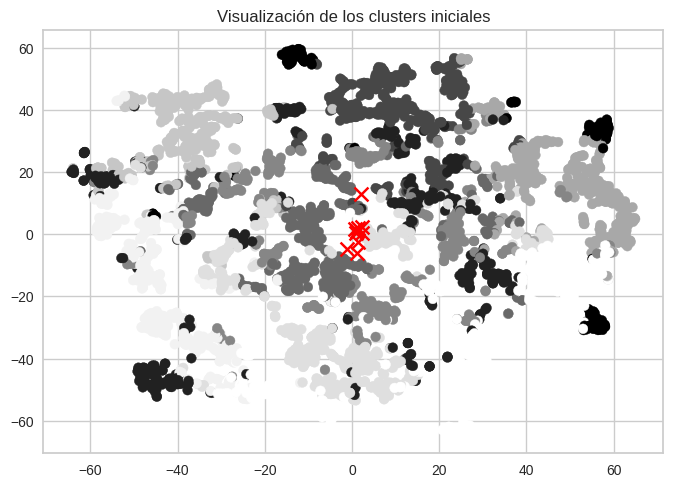

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

number_of_clusters = optimal_clusters

# Luego ajustas K-means a estas características transformadas por PCA
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(attention)

# Guardas los centros de los clústeres
cluster_centers = kmeans.cluster_centers_

# Ahora para visualizar los clusters iniciales
reduced_data = TSNE(n_components=2).fit_transform(attention)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='x')  # Centros de clusters
plt.title('Visualización de los clusters iniciales')
plt.show()


In [8]:
from sklearn.metrics import pairwise_distances
from skimage.filters import threshold_otsu
from dinov2_feature_extraction import min_max_scale, get_dense_descriptor


def pca_colorize_2(features, output_shape, clusters, threshold, remove_bg=True):
    features_components = min_max_scale(features)
    rgb = features_components.reshape(output_shape + (3,))

    if remove_bg:
        # Calcula la distancia entre cada punto de características y los centroides de los clusters
        distances = pairwise_distances(features_components, clusters)

        # Calcula la suma de las distancias a todos los centroides para cada punto
        sum_distances = np.sum(distances, axis=1)

        # Reestructura la matriz de sumas de distancias para que coincida con el formato de los componentes de PCA
        sum_distances = sum_distances.reshape(output_shape)

        # Crea una máscara basada en un umbral de distancia
        distance_mask = sum_distances < threshold

        # Aplica la máscara a todos los canales para eliminar los píxeles cercanos a los centros del cluster
        for c in range(3):
            rgb[distance_mask, c] = 0

        # Reescala los valores de la imagen
        rgb = min_max_scale(rgb)

    return rgb


In [9]:
from decimal import Decimal, getcontext

def pca_colorize_2_old(features, output_shape):
    # Aplicar PCA como antes
    inverted = False
    remove = True
    rgb = min_max_scale(features)
    rgb = rgb.reshape(output_shape + (3,))

    # Set the precision you need
    getcontext().prec = 10

    mean_color = np.mean(rgb, axis=(0, 1))
    print(mean_color)
    dominant_color = np.argmax(mean_color)
    print(dominant_color)
    # Convert numpy.float32 to native Python float, then to Decimal
    mean_color_0 = Decimal(float(mean_color[0]))
    mean_color_2 = Decimal(float(mean_color[2]))

    # Calculate the difference using Decimal
    diff =  mean_color_2-mean_color_0

    # Calculate the difference using Decimal
    diff_2 =  mean_color_0 - mean_color_2

    # Aplicar umbral de Otsu al color dominante
    thresh = threshold_otsu(rgb[:, :, 0])
    rgb_mask = (rgb[:, :, 0] > thresh)*1
    # Invertir la máscara si el color dominante no es el primero
    if dominant_color == 0 and diff_2 > Decimal('1.8e-7'):
        print("invertir")
        inverted = True
        rgb_mask = 1 - rgb_mask

    elif dominant_color == 0 and diff_2 <= Decimal('1.8e-7'):
        remove = False
    print(diff_2)

    if dominant_color == 2 and diff <= Decimal('9e-8'):
        remove = False
    rgb[:, :, 0] *= rgb_mask
    rgb[:, :, 1] *= rgb_mask
    rgb[:, :, 2] *= rgb_mask
    rgb = min_max_scale(rgb)

    return rgb, inverted, remove

import os
import torch
import numpy as np
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA

from skimage import morphology, measure

def foreground_mask_2(attention_rgb, remove, use_bbox=True):
    # Crear la máscara básica
    attention_mask = attention_rgb.mean(axis=-1) > 0
    attention_mask = morphology.binary_dilation(attention_mask)
    if remove == False:
        print("no remove")
        # Crear una matriz de unos con las mismas dimensiones que attention_mask
        return np.ones_like(attention_mask)

    if use_bbox:
        attention_labeled = measure.label(attention_mask)
        regions = measure.regionprops(attention_labeled)
        '''
        if inverted:
            # Crear una máscara invertida donde se mantenga todo excepto las bounding boxes
            inverted_mask = np.ones_like(attention_mask, dtype=bool)
            for props in regions:
                ymin, xmin, ymax, xmax = props.bbox
                inverted_mask[ymin:ymax, xmin:xmax] = False
            return inverted_mask
        
        else:
        '''
        # Proceso normal: expandir la máscara dentro de los bounding boxes
        for props in regions:
            ymin, xmin, ymax, xmax = props.bbox
            attention_mask[ymin:ymax, xmin:xmax] = True
    
    return attention_mask

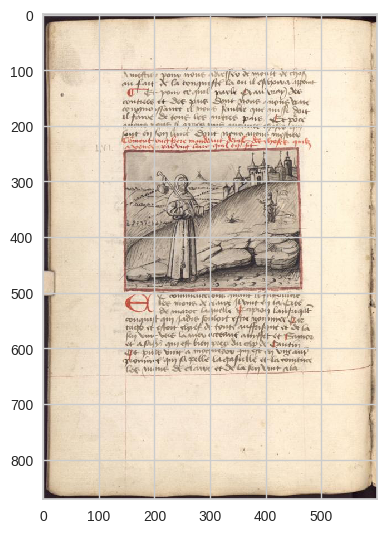

In [10]:
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1.jpg'  
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page4.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page40.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page114.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page104.jpg'   
dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/medieval_image_retrieval/DocExplore_images/page1.jpg'  
new_img = io.imread(dataset_path_new_img_1)


new_image_features, new_image_attention, new_image_grid_shape = get_dense_descriptor(model, new_img)

io.imshow(new_img)
io.show()

In [11]:
# Process the image and get the background component

test, inverted, remove = pca_colorize_2_old(new_image_attention, new_image_grid_shape)
io.imshow(test)
io.show()

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''

test_mask_box_2 = foreground_mask_2(test, remove, use_bbox=True)
io.imshow(test_mask_box_2)
io.show()

ValueError: cannot reshape array of size 999936 into shape (62,42,3)

In [13]:
# Process the image and get the background component

threshold = 102.9
test = pca_colorize_2(new_image_attention, new_image_grid_shape, cluster_centers, threshold)
io.imshow(test)
io.show()

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''



ValueError: cannot reshape array of size 999936 into shape (62,42,3)